[saving](https://www.tensorflow.org/tutorials/keras/save_and_load)

## improvements
* batch normalization

In [1]:
import os
from tqdm.notebook import tqdm
import random
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["tf_gpu_allocator"]="cuda_malloc_async"
warnings.filterwarnings("ignore")

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

import visualkeras

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!export PATH=/usr/local/cuda/bin:$PATH

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [5]:
!nvidia-smi

Wed Nov  1 09:45:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8               8W / 200W |    968MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import cv2

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, ReLU, LeakyReLU, BatchNormalization, Add, Input, concatenate
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import RandomCrop, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Resizing, Rescaling

from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight

In [8]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

The dataset consists of labelled images of vegetables including:
* Bean
* Bitter_Gourd
* Bottle_Gourd
* Brinjal
* Broccoli
* Cabbage
* Capsicum
* Carrot
* Cauliflower
* Cucumber
* Papaya
* Potato
* Pumpkin
* Radish
* Tomato

Provided are a train set (inconsistent number of samples for each class), a train set (200 samples/class), and a validation set (200 samples/class).

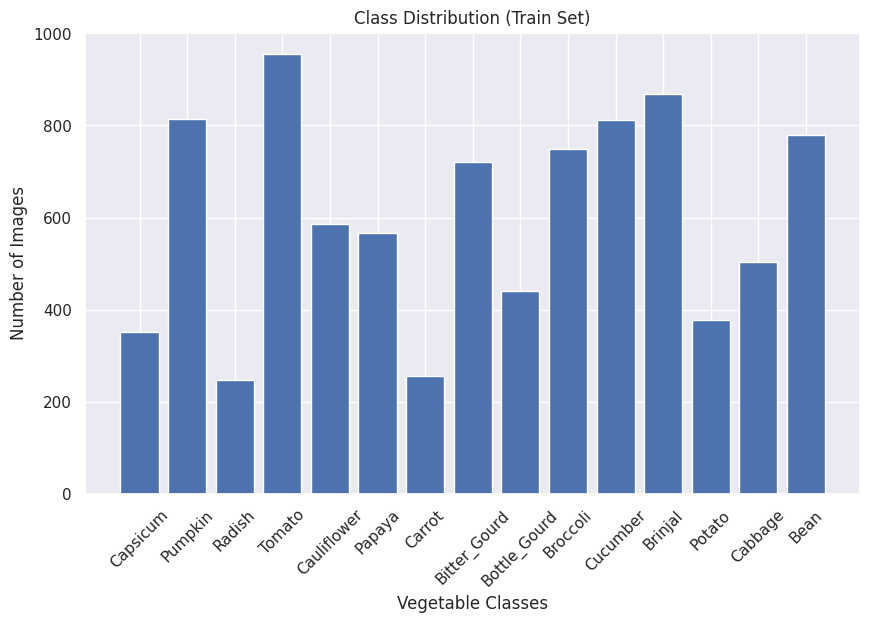

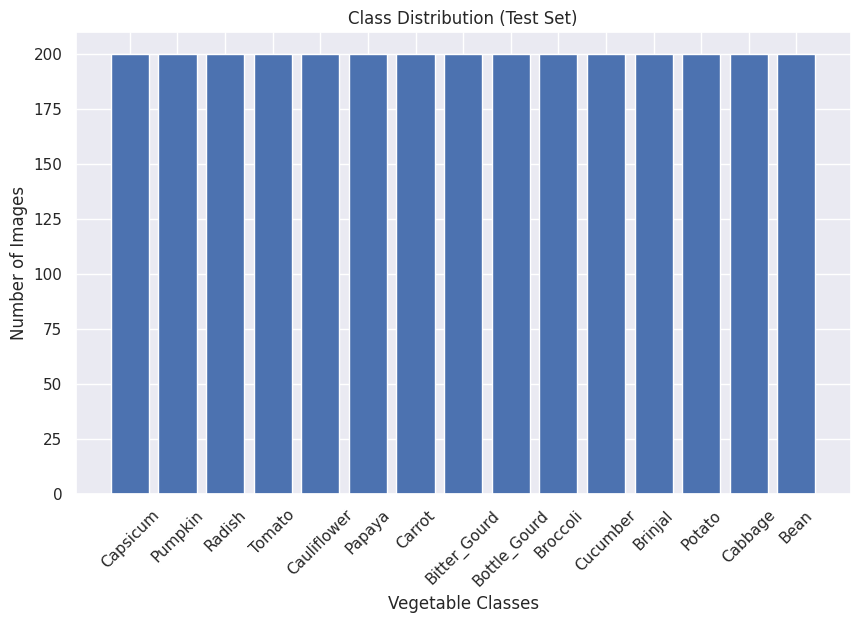

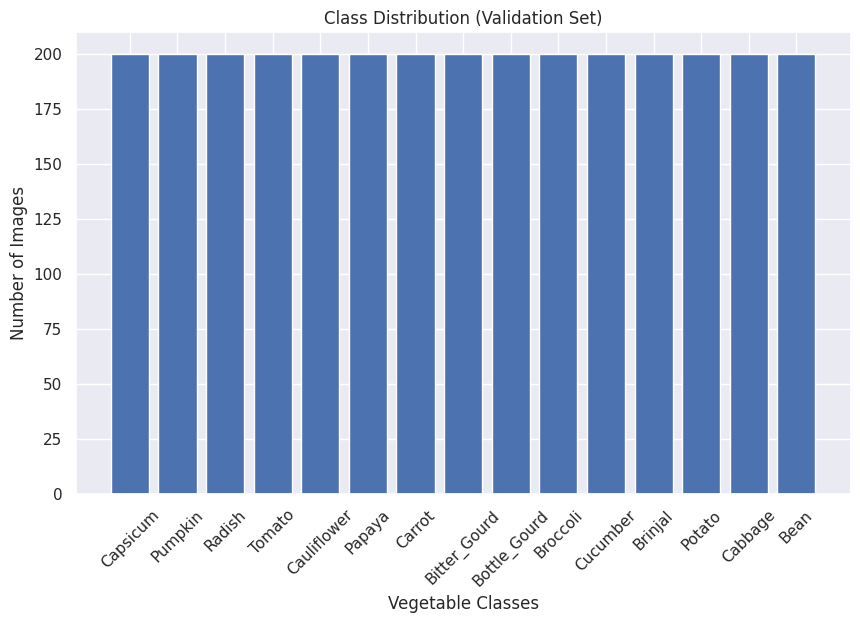

In [9]:
def plot_class_count_dir(dir, train):
    # Count the number of images in each class
    class_counts = {}
    for subdir, _, files in os.walk(dir):
        if subdir.split("/")[-1] != "":
            class_counts[subdir.split("/")[-1]] = len(files)
    
    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Vegetable Classes')
    plt.ylabel('Number of Images')
    plt.title(train)
    plt.xticks(rotation=45)
    plt.show()

plot_class_count_dir('Vegetable Images/train/', 'Class Distribution (Train Set)')
plot_class_count_dir('Vegetable Images/test/', 'Class Distribution (Test Set)')
plot_class_count_dir('Vegetable Images/validation/', 'Class Distribution (Validation Set)')

* Imbalanced Dataset
* Will have to via adjusting class weights, penalising the model more for incorrect classification of lower frequency class

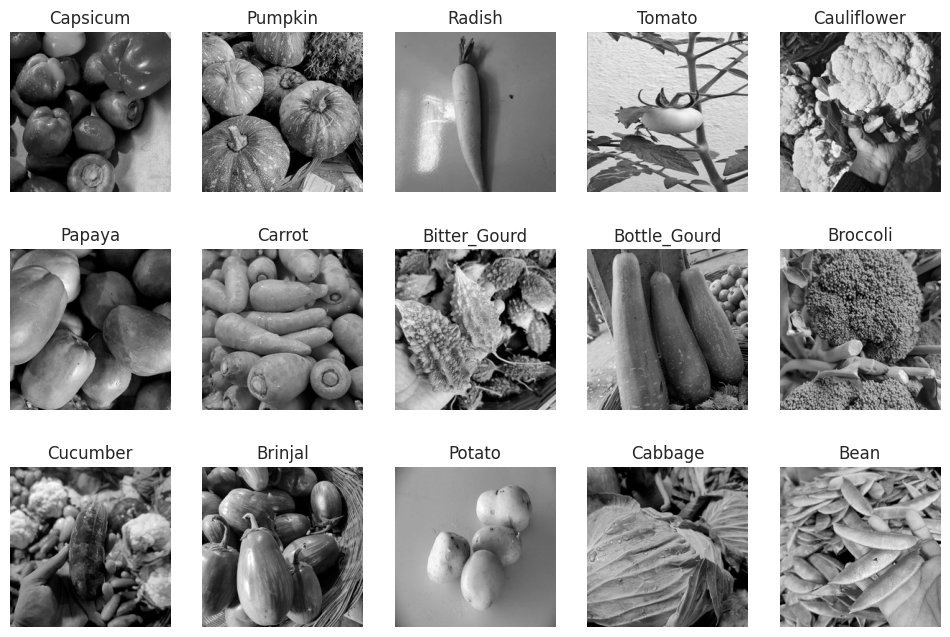

In [10]:
plt.figure(figsize=(12, 8))
for i in range(15):
    subdir = os.listdir('Vegetable Images/train/')[i]
    img_file = random.choice(os.listdir(os.path.join('Vegetable Images/train/', subdir)))
    img_path = os.path.join('Vegetable Images/train', subdir, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(subdir)
    plt.axis('off')
plt.show()

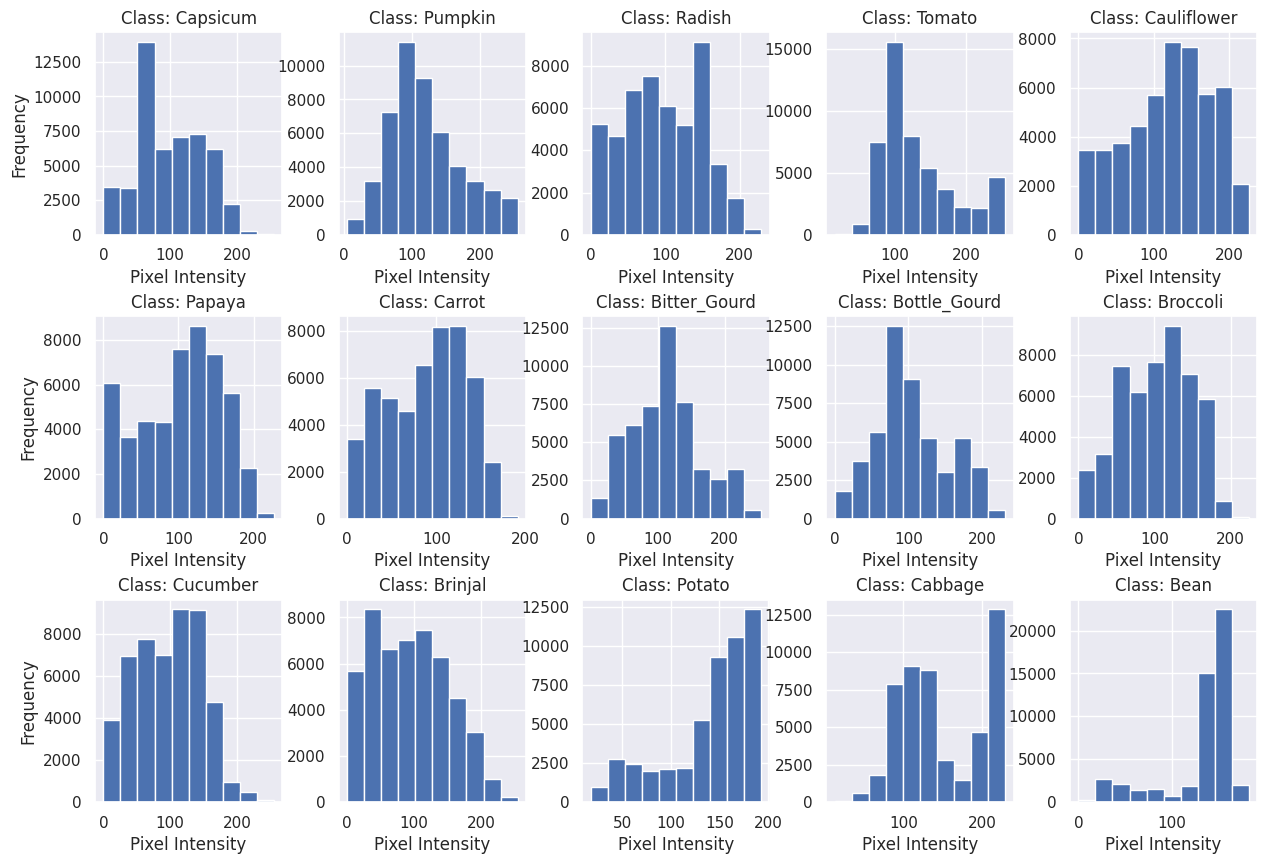

In [11]:
def plot_intensity_histogram(image_path, class_name, ax):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.hist(img.ravel())
    ax.set_xlabel('Pixel Intensity')
    ax.set_title(f'Class: {class_name}')
    return ax

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

class_folders = os.listdir('Vegetable Images/train/')
for i, class_folder in enumerate(class_folders):
    sample_image_path = os.path.join('Vegetable Images/train/', class_folder, os.listdir(f'Vegetable Images/train/{class_folder}')[0])
    row = i // 5
    col = i % 5
    ax = plot_intensity_histogram(sample_image_path, class_folder, axes[row, col])
    if col == 0:
        ax.set_ylabel('Frequency')

plt.show()

In [12]:
class_keys = {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}

inverted_class_keys = {v: k for k, v in class_keys.items()}

In [13]:
train_dir = 'Vegetable Images/train/'
test_dir = 'Vegetable Images/test/'
validation_dir = 'Vegetable Images/validation/'

In [119]:
train = image_dataset_from_directory(train_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")
test = image_dataset_from_directory(test_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")
validation = image_dataset_from_directory(validation_dir, batch_size=None, image_size=(224, 224), color_mode="grayscale", label_mode="categorical")

Found 9028 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Preprocessing: Data Augmentation 
#### Reasoning:
* Data augmentation effectively increases the size of the training dataset. With more diverse examples, the model can learn a broader range of patterns and become more robust. Especially with some classes only having about 200 training samples.
* Model will be more generalized and reduces overfitting from memorizing specific examples.

In [192]:
# extremely slow in TF 2.10.0, can slow model as much as 6x

prep = Sequential(
    [
        Rescaling(1./255),
    ],
    name="preprocessing"
)

image_augmentation = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomContrast(0.5),
        RandomRotation((-0.35, 0.35)),
        RandomZoom(0.2, 0.2)
    ],
    # name="image_augmentation"
)

def resize_small(image, label):
    return Resizing(31, 31)(image), label

def resize_large(image, label):
    return Resizing(128, 128)(image), label

def expand_dims(image, label):
    # image = tf.expand_dims(image, axis=-1)
    return image, label

# train_single_channel = train.map(expand_dims)
# validation_single_channel = validation.map(expand_dims)
# test_single_channel = test.map(expand_dims)

small_train = train.map(resize_small).map(expand_dims)
small_validation = validation.map(resize_small).map(expand_dims)
small_test = test.map(resize_small).map(expand_dims)

large_train = train.map(resize_large).map(expand_dims)
large_validation = validation.map(resize_large).map(expand_dims)
large_test = test.map(resize_large).map(expand_dims)

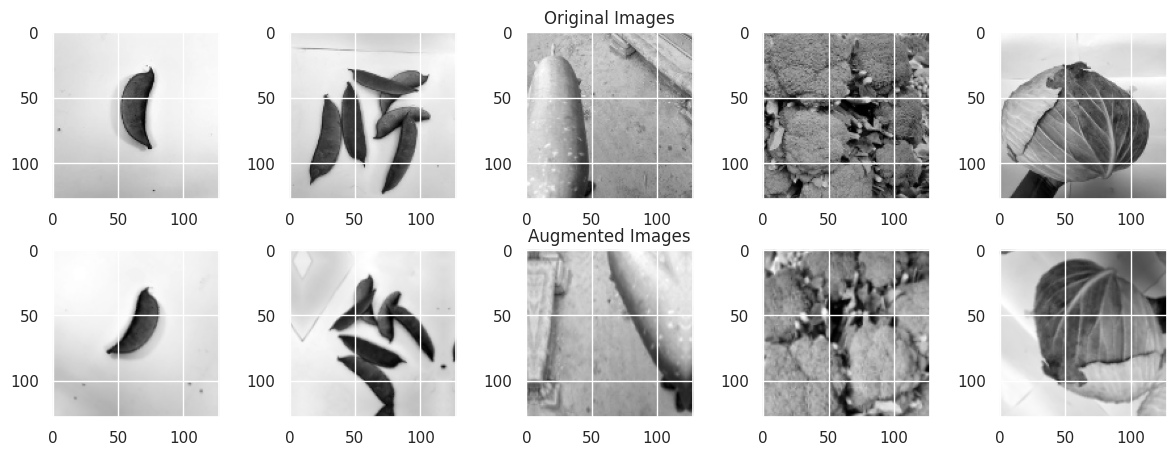

In [186]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# axes = np.flatten(axes)
plt.subplots_adjust(hspace=0.3, wspace=0.1)

for i, (image, label) in enumerate(large_train.take(5)):
    # print(image.shape)
    axes[0][i].imshow(image, cmap="gray")
    axes[1][i].imshow(image_augmentation(image), cmap="gray")
    
    
axes[0][2].set_title("Original Images")
axes[1][2].set_title("Augmented Images")
    
plt.show()

This data augmentation is added as a preprocessing layer in the model and applied during model training.

### Calculating Class Weights

In [124]:
class_series = np.argmax(train_labels, axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
class_weights = dict(zip(class_labels, class_weights))
print(class_weights)

NameError: name 'train_labels' is not defined

Classes with the lowest sample count in the training set will have the greatest weight eg. 13: Radish

In [187]:
def fit_model(model, train, val, test, filepath=""):
    # model.summary()
    if filepath != "":
        cp_callback = ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True, verbose=1, save_freq='epoch')
        
        history = model.fit(
            train.batch(32),
            # x = datagen.flow(train, train_labels, batch_size=64),
            epochs=50,
            batch_size=32,
            validation_data=(val.batch(32)),
            callbacks=[cp_callback],
            # class_weight=class_weights
        )
    else:
        history = model.fit(
            train.batch(32),
            # x = datagen.flow(train, train_labels, batch_size=64),
            epochs=50,
            batch_size=32,
            validation_data=(val.batch(32)),
            # callbacks=[cp_callback],
            # class_weight=class_weights
        )
    
    accuracy = model.evaluate(test.batch(32), verbose=0)[1]
    
    print(f"Accuracy for images: {accuracy:.2f}")

    return history

In [ ]:
def plot_history(history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(title)
    
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    
    left_legend = []
    for k, v in history.items():
        ax[0].plot(v.history['accuracy'])
        ax[0].plot(v.history['val_accuracy'])
        left_legend += [f'{k} Train', f'{k} Validation']
    ax[0].legend(left_legend, loc='lower right')
    
    right_legend = []
    for k, v in history.items():
        ax[1].plot(v.history['loss'])
        ax[1].plot(v.history['val_loss'])
        right_legend += [f'{k} Train', f'{k} Validation']
    ax[1].legend(right_legend, loc='upper left')
    
    plt.tight_layout()

    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')
    plt.show()

# Models for Large Images (128, 128)

## Simple CNN (Base Model)
2x Convolution Blocks

In [189]:
simple_CNN_history = {}

In [194]:
simple_CNN_no_augmentation = Sequential([
    prep,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    # Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_no_augmentation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["Without Image Augmentation"] = fit_model(simple_CNN_no_augmentation, large_train, large_validation, large_test)

simple_CNN = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["With Image Augmentation"] = fit_model(simple_CNN, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 5s 15ms/step - loss: 1.8767 - accuracy: 0.4065 - val_loss: 1.3444 - val_accuracy: 0.5817
Epoch 2/50
283/283 [==============================] - 4s 14ms/step - loss: 0.8274 - accuracy: 0.7401 - val_loss: 0.8706 - val_accuracy: 0.7393
Epoch 3/50
283/283 [==============================] - 4s 14ms/step - loss: 0.3271 - accuracy: 0.8993 - val_loss: 0.9327 - val_accuracy: 0.7503
Epoch 4/50
283/283 [==============================] - 4s 14ms/step - loss: 0.1354 - accuracy: 0.9597 - val_loss: 0.8965 - val_accuracy: 0.7733
Epoch 5/50
283/283 [==============================] - 4s 14ms/step - loss: 0.0479 - accuracy: 0.9862 - val_loss: 1.1459 - val_accuracy: 0.7563
Epoch 6/50
283/283 [==============================] - 4s 14ms/step - loss: 0.0451 - accuracy: 0.9870 - val_loss: 1.2052 - val_accuracy: 0.7453
Epoch 7/50
283/283 [==============================] - 4s 14ms/step - loss: 0.0434 - accuracy: 0.9874 - val_loss: 1.6398 - val_accuracy: 0.7143

In [202]:
simple_CNN.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 sequential_67 (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 conv2d_81 (Conv2D)          (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_82 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                               

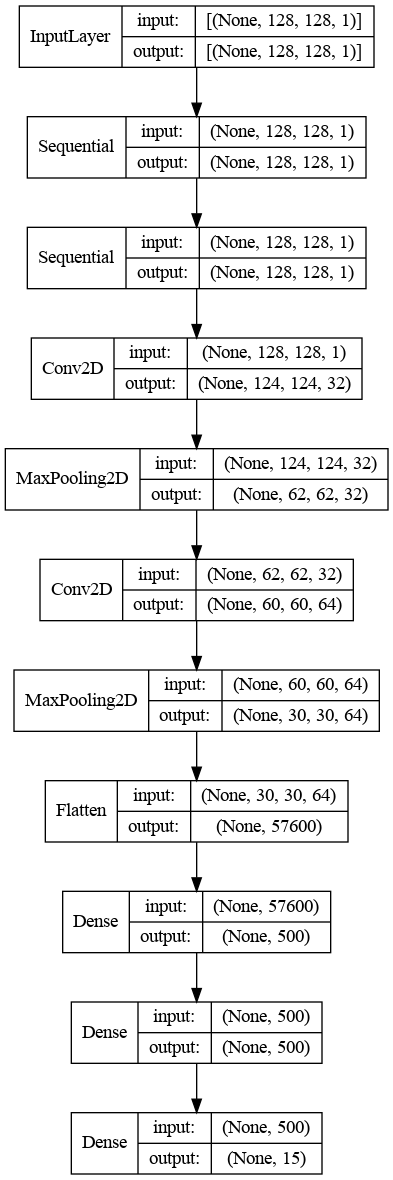

In [195]:
plot_model(simple_CNN, to_file='images/models/simple_CNN_large_images.png', show_shapes=True, show_layer_names=False)

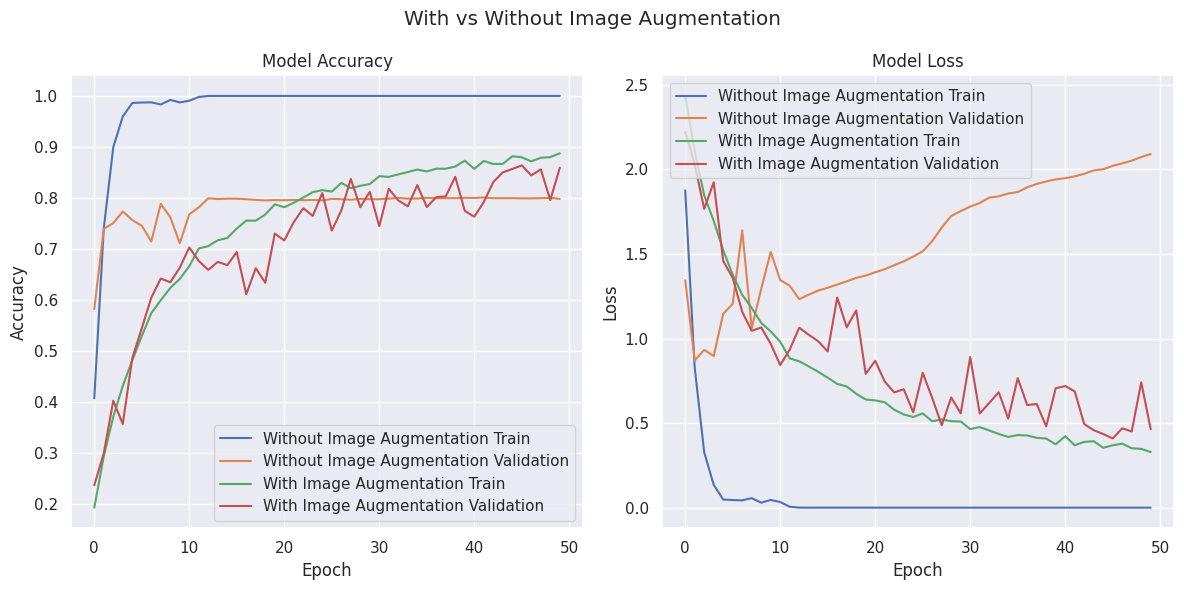

In [199]:
plot_history(simple_CNN_history, "With vs Without Image Augmentation", savefig="images/With and Without Image Augmentation.png")

Without Data Augmentation, the model starts overfitting very quickly and validation loss diverges over time while training loss converges.

In [200]:
simple_CNN_history.pop("Without Image Augmentation")

In [ ]:
simple_CNN_history

## Improvements

More Convolutional Blocks

In [205]:
simple_CNN_4_Conv = Sequential([
    prep,
    image_augmentation,
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
simple_CNN_4_Conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

simple_CNN_history["4x Conv"] = fit_model(simple_CNN_4_Conv, large_train, large_validation, large_test)

Epoch 1/50
283/283 [==============================] - 6s 17ms/step - loss: 2.6334 - accuracy: 0.0991 - val_loss: 2.7179 - val_accuracy: 0.0667
Epoch 2/50
283/283 [==============================] - 5s 16ms/step - loss: 2.5187 - accuracy: 0.1479 - val_loss: 2.4237 - val_accuracy: 0.1757
Epoch 3/50
283/283 [==============================] - 5s 16ms/step - loss: 2.2072 - accuracy: 0.2541 - val_loss: 2.1109 - val_accuracy: 0.2857
Epoch 4/50
283/283 [==============================] - 5s 16ms/step - loss: 1.8722 - accuracy: 0.3778 - val_loss: 1.9060 - val_accuracy: 0.3680
Epoch 5/50
283/283 [==============================] - 5s 16ms/step - loss: 1.6351 - accuracy: 0.4515 - val_loss: 1.6297 - val_accuracy: 0.4690
Epoch 6/50
283/283 [==============================] - 5s 16ms/step - loss: 1.4273 - accuracy: 0.5216 - val_loss: 1.3028 - val_accuracy: 0.5580
Epoch 7/50
283/283 [==============================] - 5s 16ms/step - loss: 1.2892 - accuracy: 0.5593 - val_loss: 1.4748 - val_accuracy: 0.5020

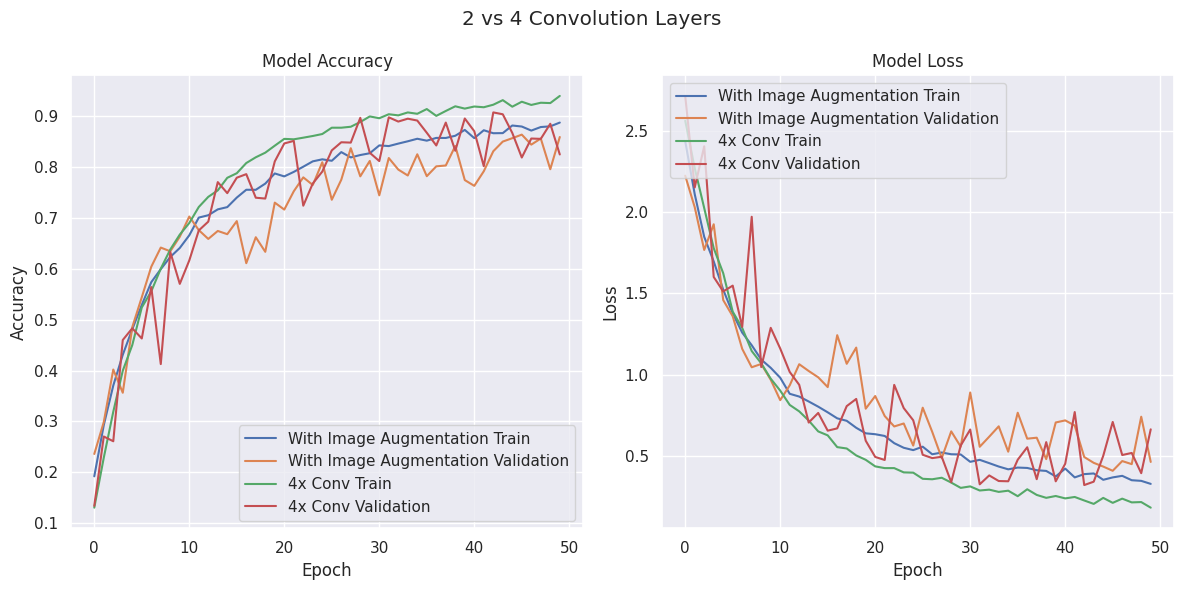

In [204]:
plot_history(simple_CNN_history, "2 vs 4 Convolution Layers", savefig="images/2vs4ConvolutionLayers.png")

## Basic CNN model à la VGG with 
* Image Augmentation Preprocessing

In [ ]:
filter=(3, 3)

model_large = Sequential([
    Rescaling(1./255, input_shape=(128, 128, 1)),
    image_augmentation,
    Conv2D(32, filter, activation='relu'),
    Conv2D(32, filter, activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, filter, activation='relu'),
    Conv2D(64, filter, activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, filter, activation='relu'),
    Conv2D(128, filter, activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, filter, activation='relu'),
    Conv2D(256, filter, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model_large.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_folder_path = "training_checkpoints/"

# example filepath large_weights.{epoch:02d}-{val_loss:.2f}.hdf5

history = fit_model(model_large, large_train_images, large_val_images, large_test_images, "training_checkpoints/simple_large_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5")

Epoch 1/50
141/142 [============================>.] - ETA: 0s - loss: 2.6811 - accuracy: 0.0744
Epoch 1: val_loss improved from inf to 2.50368, saving model to training_checkpoints/simple_large_weights.01-0.11.hdf5
142/142 [==============================] - 19s 47ms/step - loss: 2.6828 - accuracy: 0.0744 - val_loss: 2.5037 - val_accuracy: 0.1107
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 2.5539 - accuracy: 0.1136
Epoch 2: val_loss improved from 2.50368 to 2.41580, saving model to training_checkpoints/simple_large_weights.02-0.16.hdf5
142/142 [==============================] - 6s 40ms/step - loss: 2.5539 - accuracy: 0.1136 - val_loss: 2.4158 - val_accuracy: 0.1620
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 2.4215 - accuracy: 0.1570
Epoch 3: val_loss did not improve from 2.41580
142/142 [==============================] - 6s 39ms/step - loss: 2.4215 - accuracy: 0.1570 - val_loss: 2.4701 - val_accuracy: 0.1667
Epoch 4/50
142/142 [======

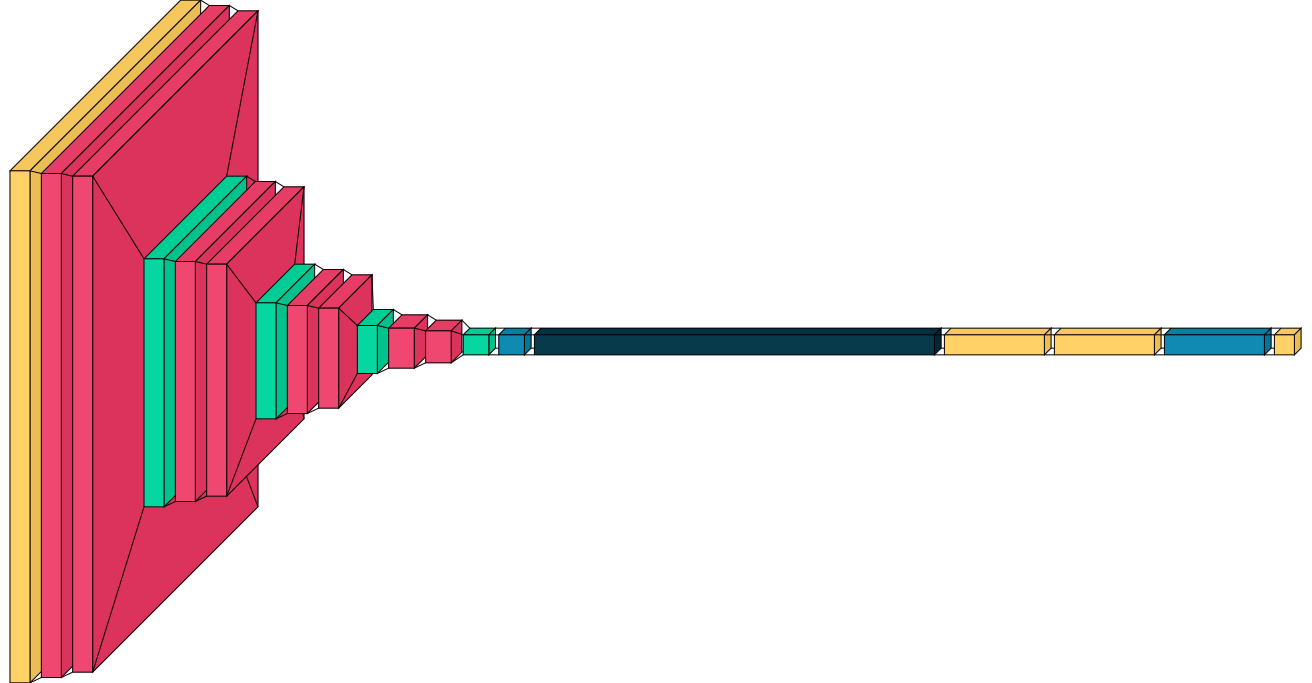

In [93]:
visualkeras.layered_view(model_large)

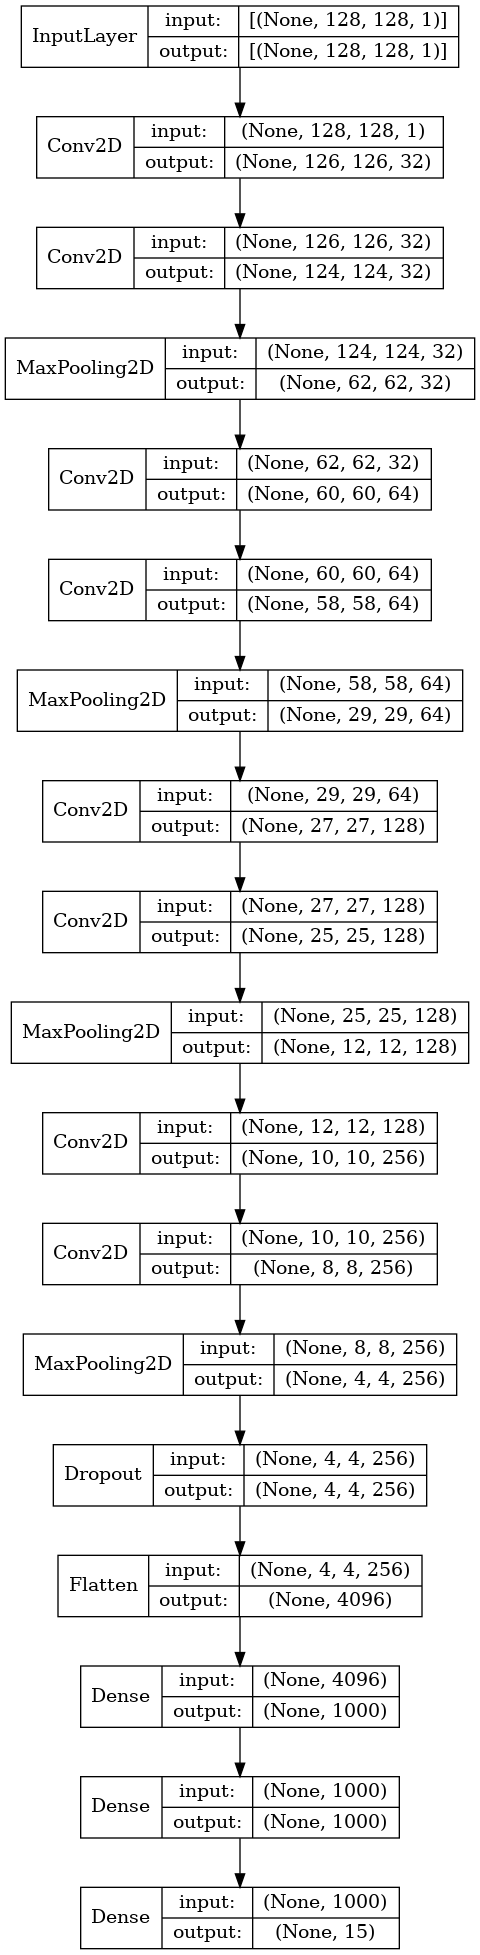

In [18]:
plot_model(model_large, to_file='images/models/simple_CNN_large_images.png', show_shapes=True, show_layer_names=False)

In [97]:
def plot_history(history, title, savefig=""):
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    fig.suptitle(title)
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()
, title, savefig=""
    if savefig != "":
        fig.savefig(savefig, bbox_inches='tight')

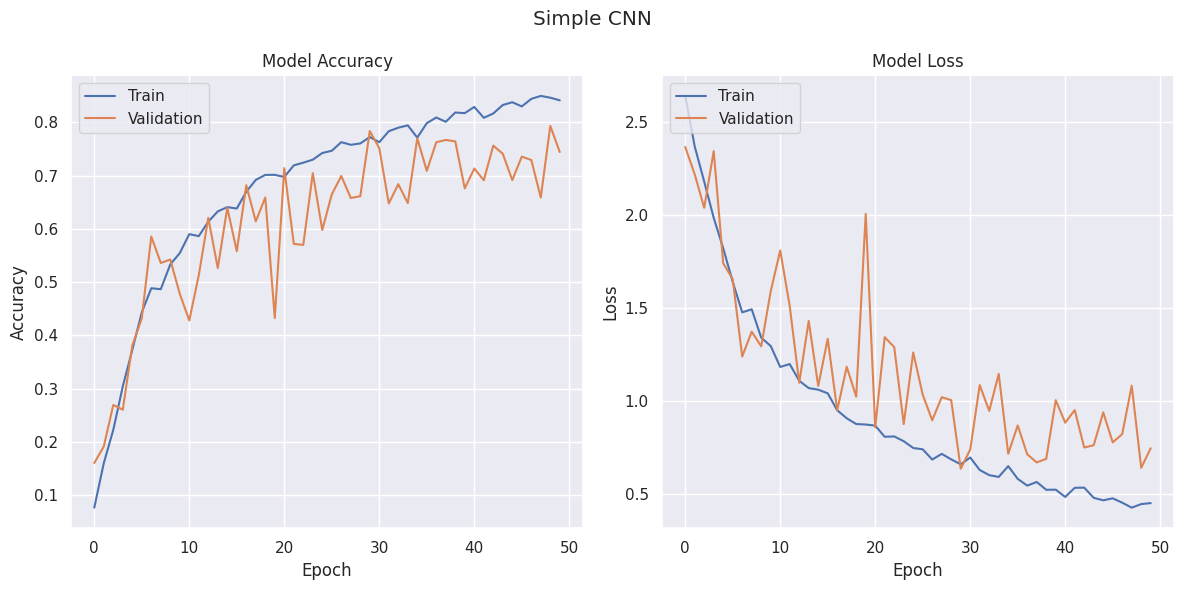

In [104]:
plot_history(history, "Simple CNN", "images/Simple CNN.png")

## ResNet

In [21]:
# https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet(shape, classes, block_count):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = Rescaling(1./255)(x_input)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [2, 2, 2, 2]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(block_count):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(100, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [22]:
resnet = ResNet((128, 128, 1), 15, block_count=2)

learning_rate_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)

resnet.compile(optimizer=Adam(learning_rate=learning_rate_decay), loss="binary_crossentropy", metrics=['accuracy'])

history = fit_model(resnet, large_train_images, large_val_images, large_test_images, "training_checkpoints/resnet_large_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5")

Epoch 1/50
141/142 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.2318
Epoch 1: val_loss improved from inf to 0.23448, saving model to training_checkpoints/resnet_large_weights.01-0.16.hdf5
142/142 [==============================] - 7s 32ms/step - loss: 0.2355 - accuracy: 0.2334 - val_loss: 0.2345 - val_accuracy: 0.1583
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.4473
Epoch 2: val_loss did not improve from 0.23448
142/142 [==============================] - 5s 33ms/step - loss: 0.1727 - accuracy: 0.4473 - val_loss: 0.2525 - val_accuracy: 0.2583
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.5397
Epoch 3: val_loss improved from 0.23448 to 0.16191, saving model to training_checkpoints/resnet_large_weights.03-0.51.hdf5
142/142 [==============================] - 5s 32ms/step - loss: 0.1494 - accuracy: 0.5397 - val_loss: 0.1619 - val_accuracy: 0.5057
Epoch 4/50
142/142 [=======

In [ ]:

resnet.compile(optimizer=RMSprop(learning_rate=learning_rate_decay, momentum=0.1), loss="binary_crossentropy", metrics=['accuracy'])


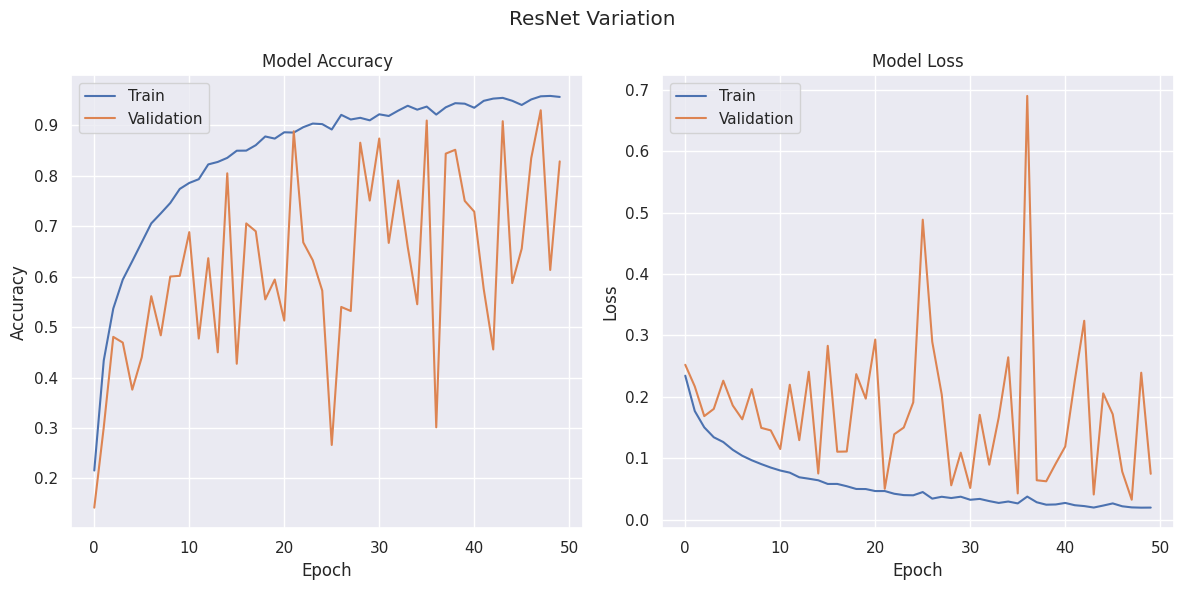

In [227]:
plot_history(history, "ResNet Variation")

In [214]:
resnet.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 zero_padding2d_21 (ZeroPad  (None, 134, 134, 1)          0         ['input_22[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv2d_792 (Conv2D)         (None, 67, 67, 64)           3200      ['zero_padding2d_21[0][0]']   
                                                                                                  
 batch_normalization_341 (B  (None, 67, 67, 64)           256       ['conv2d_792[0][0]']   

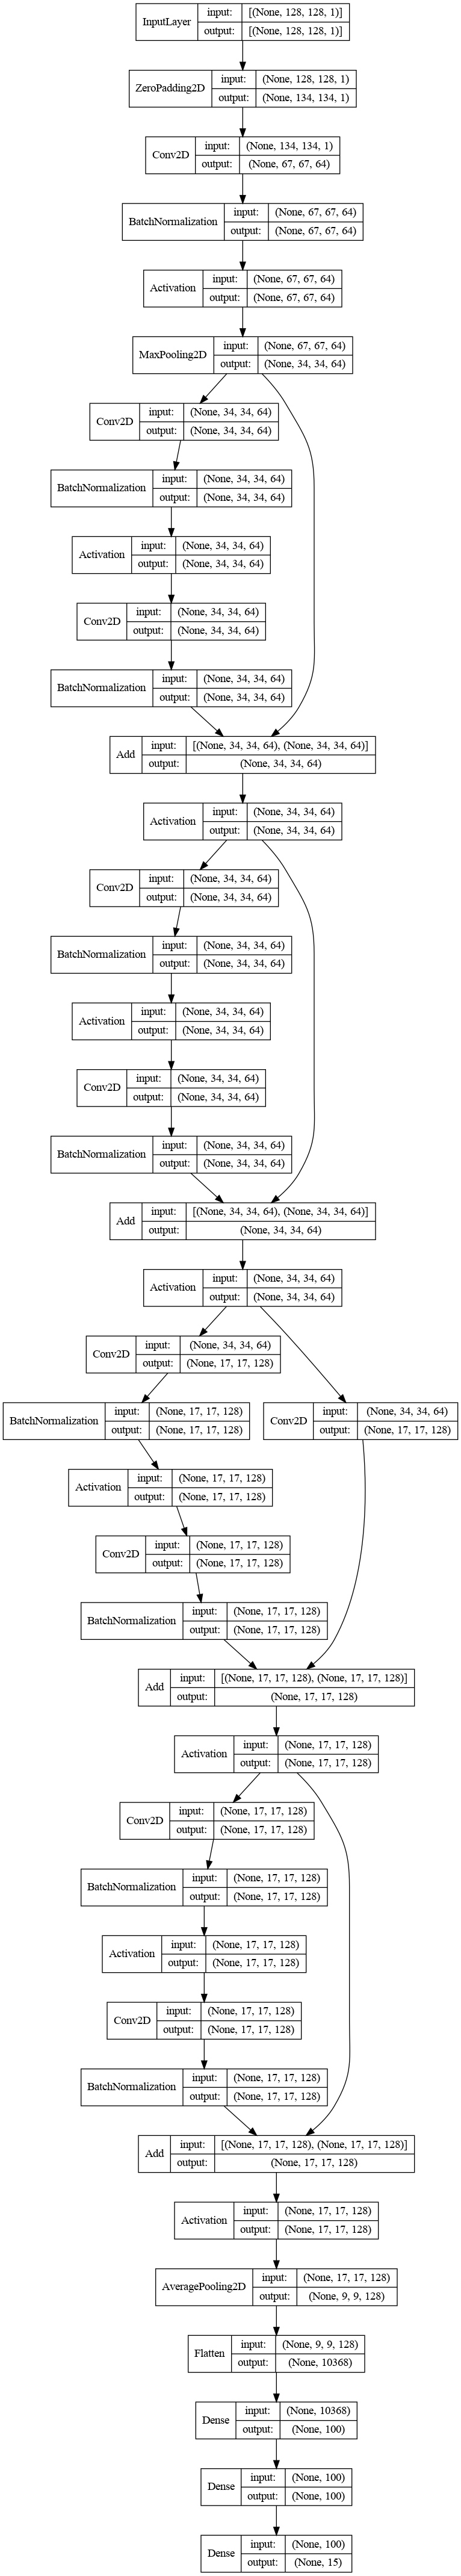

In [225]:
plot_model(resnet, "images/Resnet.png", show_shapes=True, show_layer_names=False)

In [223]:
# Loads the weights
model = ResNet((128, 128, 1), 15, block_count=2)
model.load_weights("training_checkpoints/resnet_large_weights.48-0.93.hdf5")
model.compile(optimizer=Adam(learning_rate=learning_rate_decay), loss="binary_crossentropy", metrics=['accuracy'])

# Re-evaluate the model
loss, acc = model.evaluate(large_test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

94/94 - 1s - loss: 0.0333 - accuracy: 0.9237 - 817ms/epoch - 9ms/step
Restored model, accuracy: 92.37%


In [164]:
# def make_simple_CNN(
#     input_shape, 
#     activation="leaky_relu", 
#     conv_block_count=4,
#     conv_block_convs_count=2,
#     dense_layer_count=2, 
#     dense_units=1000, 
#     filter_shape=(3, 3), 
#     optimizer="adam", 
#     learning_rate=0.0001, 
#     learning_rate_decay=True, 
#     filter = [32, 64, 128, 256, 512], 
#     leaky_relu_alpha = 0.01, 
#     pooling="max", 
#     pooling_size=(2, 2),  
#     regularizer="l2", 
#     l1_penalty=0.01, 
#     l2_penalty=0.01, 
#     dropout=True,
#     dropout_rate=0.5,
#     momentum=0.0,
#     nesterov=False,
#     weight_decay=None,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']nr
# ):
#     model = Sequential([Rescaling(1./255, input_shape=input_shape)])
#     kernel_regularizer=l2(0.01)
#     # filter = 32
#     kernel_regularizer = None
#     regularizers = {"l1": L1(l1_penalty), "l2": L2(l2_penalty), "l1l2": L1L2(l1_penalty, l2_penalty)}
#     if regularizer in regularizers.keys():
#         kernel_regularizer = regularizers[regularizer]

#     activations = {"relu": ReLU, "leaky_relu": LeakyReLU, }
#     if activation in activations.keys():
#         if activation == "leaky_relu":
#             activation_fn = activations[activation]
#         else:
#             activation_fn = activations[activation]
#     else:
#         activation_fn = ReLU

    
#     poolings = {"max": MaxPooling2D, "average": AveragePooling2D}
#     if pooling in poolings.keys():
#         pooling = poolings[pooling]
#     else:
#         pooling = MaxPooling2D

#     for i in range(conv_block_count):
#         for j in range(conv_block_convs_count):
#             model.add(Conv2D(filter[i], filter_shape, kernel_regularizer=kernel_regularizer))
#             model.add(activation_fn(leaky_relu_alpha))
#         model.add(pooling(pooling_size))
#         if dropout:
#             model.add(Dropout(dropout_rate))
#     model.add(Flatten())
#     for i in range(dense_layer_count):
#         model.add(Dense(dense_units))
#         model.add(activation_fn(leaky_relu_alpha))
#     model.add(Dense(15, activation="softmax"))

#     if learning_rate_decay:
#         learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#             learning_rate,
#             decay_steps=100000,
#             decay_rate=0.96,
#             staircase=True
#         )
    
#     optimizers = {
#         "adam": Adam(
#             learning_rate=learning_rate,
#             beta_1=beta_1,
#             beta_2=beta_2,
#             epsilon=epsilon,
#             amsgrad=amsgrad,
#         ), 
#         "sgd": SGD(
#             learning_rate=learning_rate,
#             momentum=momentum,
#             nesterov=nesterov,
#             weight_decay=weight_decay,
#         )
#     }
#     if optimizer in optimizers.keys():
#         optimizer = optimizers[optimizer]
#     model.compile(optimizer = optimizer, loss=loss, metrics=metrics)
#     return model

In [167]:
simple_CNN_large = make_simple_CNN((128, 128, 1), optimizer="sgd", learning_rate=0.01)

In [168]:
history = fit_model(simple_CNN_large, large_train_images, large_val_images, large_test_images, "training_checkpoints/simple_large_weights.{epoch:02d}-{val_accuracy:.2f}.hdf5")

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 10.3001 - accuracy: 0.0711
Epoch 1: val_loss improved from inf to 10.08462, saving model to training_checkpoints/simple_large_weights.01-0.07.hdf5
142/142 [==============================] - 6s 38ms/step - loss: 10.3001 - accuracy: 0.0711 - val_loss: 10.0846 - val_accuracy: 0.0667
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 9.8783 - accuracy: 0.0583
Epoch 2: val_loss improved from 10.08462 to 9.67739, saving model to training_checkpoints/simple_large_weights.02-0.07.hdf5
142/142 [==============================] - 5s 37ms/step - loss: 9.8783 - accuracy: 0.0583 - val_loss: 9.6774 - val_accuracy: 0.0720
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 9.4815 - accuracy: 0.0511
Epoch 3: val_loss improved from 9.67739 to 9.29315, saving model to training_checkpoints/simple_large_weights.03-0.07.hdf5
142/142 [==============================] - 5s 37ms/step - loss: 9.4815 - accur

KeyboardInterrupt: 

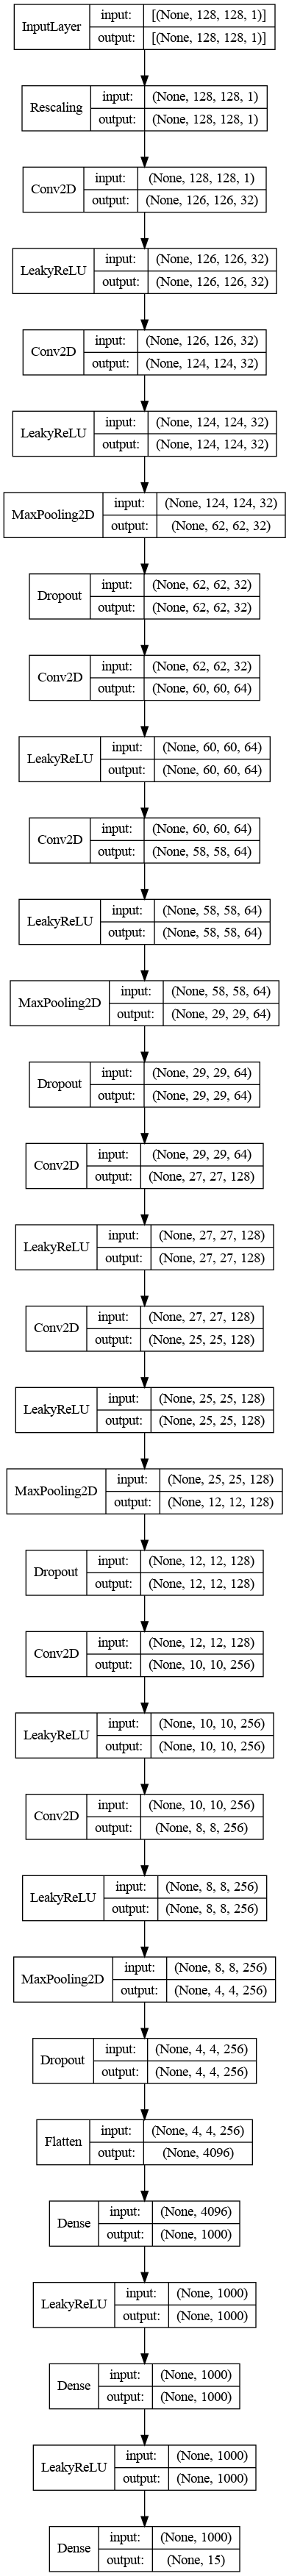

In [180]:
model_upscaled_small = tf.keras.models.clone_model(model_large, input_tensors=Input(shape=(128, 128, 1)))

model_upscaled_small.set_weights(model_large.get_weights())

# Compile the model
model_upscaled_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ModelCheckpoint(filepath=checkpoint_paths["simple_large"], save_weights_only=True, verbose=1)

cp_callback = ModelCheckpoint(filepath=checkpoint_paths["simple_upscaled_small"], save_weights_only=True, verbose=1)

history = model_upscaled_small.fit(
    x = datagen.flow(resize_large(small_train_images), train_labels, batch_size=50),
    epochs=50,
    batch_size=50,
    validation_data=(resize_large(small_val_images), val_labels),
    callbacks=[cp_callback]
)

accuracy = model_upscaled_small.evaluate(resize_large(small_test_images), test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {accuracy:.2f}")

Epoch 1/50
179/181 [============================>.] - ETA: 0s - loss: 1.4936 - accuracy: 0.5172
Epoch 1: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 7s 31ms/step - loss: 1.4920 - accuracy: 0.5179 - val_loss: 1.0361 - val_accuracy: 0.6397
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.6125
Epoch 2: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 6s 30ms/step - loss: 1.1289 - accuracy: 0.6125 - val_loss: 1.0203 - val_accuracy: 0.6523
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 1.0207 - accuracy: 0.6589
Epoch 3: saving model to training_checkpoints/simple_upscaled_small.ckpt
181/181 [==============================] - 5s 30ms/step - loss: 1.0207 - accuracy: 0.6589 - val_loss: 0.8294 - val_accuracy: 0.7123
Epoch 4/50
180/181 [============================>.] - ETA: 0s - loss: 0.9749 - accuracy: 0.6675
E

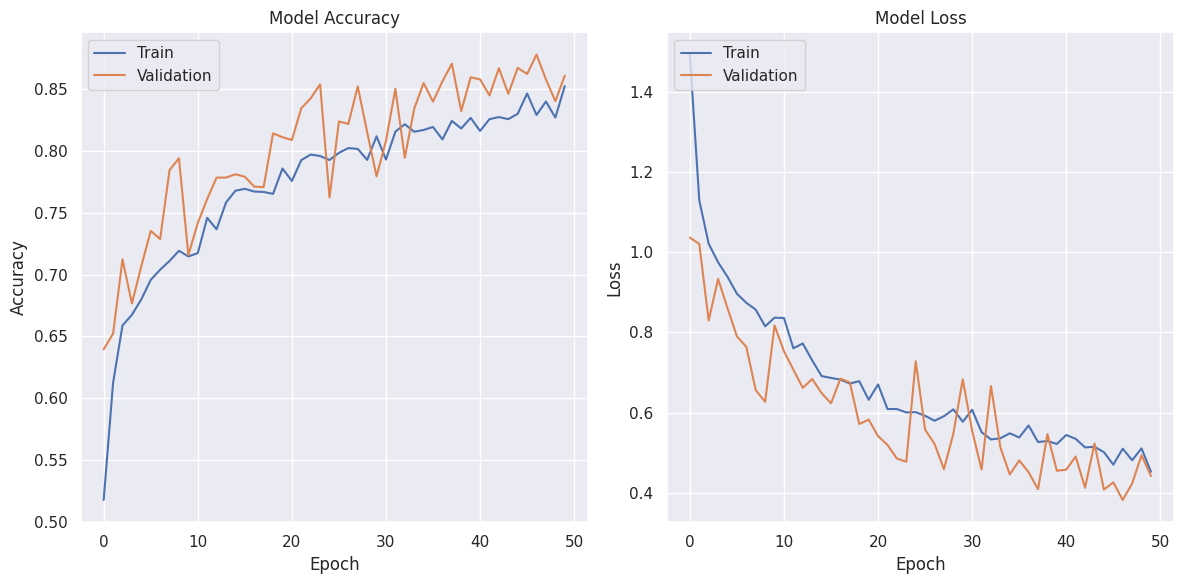

In [181]:
plot_history(history)

In [52]:
model_upscaled_small.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 126, 126, 32)      320       
                                                                 
 conv2d_111 (Conv2D)         (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 60, 60, 64)        18496     
                                                                 
 conv2d_113 (Conv2D)         (None, 58, 58, 64)        36928     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 29, 29, 64)        0         
 ng2D)                                                

In [104]:
[x.shape for x in activations]

[TensorShape([1, 126, 126, 32]),
 TensorShape([1, 124, 124, 32]),
 TensorShape([1, 62, 62, 32]),
 TensorShape([1, 60, 60, 64]),
 TensorShape([1, 58, 58, 64]),
 TensorShape([1, 29, 29, 64]),
 TensorShape([1, 27, 27, 128]),
 TensorShape([1, 25, 25, 128]),
 TensorShape([1, 12, 12, 128]),
 TensorShape([1, 10, 10, 256]),
 TensorShape([1, 8, 8, 256]),
 TensorShape([1, 4, 4, 256]),
 TensorShape([1, 4, 4, 256]),
 TensorShape([1, 4096]),
 TensorShape([1, 1000]),
 TensorShape([1, 1000]),
 TensorShape([1, 15])]

In [28]:
layer_outputs = [layer.output for layer in model_large.layers]  # Choose the layers you want to visualize
activation_model = Model(inputs=model_large.input, outputs=layer_outputs)

# Wrap the code inside a tf.function to prevent excessive retracing
@tf.function
def get_activations(input_data):
    return activation_model(input_data)

def display_conv_activation(image_index, activation_index, figsize=(32, 32)):

    # Get activations for a specific layer for a sample input
    # activations = get_activations(np.expand_dims(resize_large(small_train_images)[image_index], axis=0))
    activations = get_activations(np.expand_dims(large_train_images)[image_index], axis=0)

    activation_size = [x.shape for x in activations][activation_index][-1]
    nrows = 4 if activation_size==32 else 8 if activation_size==64 or activation_size==128 else 16
    ncols = 8 if activation_size==32 or activation_size==64 else 16

    plt.figure(figsize=figsize)
    # plt.title(f"{inverted_class_keys[train_labels[1].argmax()]} Image, Activation Layer {activation_index}", fontsize = 40)
    for i in range(activation_size):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(activations[activation_index][0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

def display_vege(image_index):
    plt.title(inverted_class_keys[train_labels[1].argmax()])
    plt.imshow(resize_large(small_train_images)[image_index], cmap='viridis')
    plt.colorbar(orientation='vertical')
    plt.show()

NameError: name 'model_large' is not defined

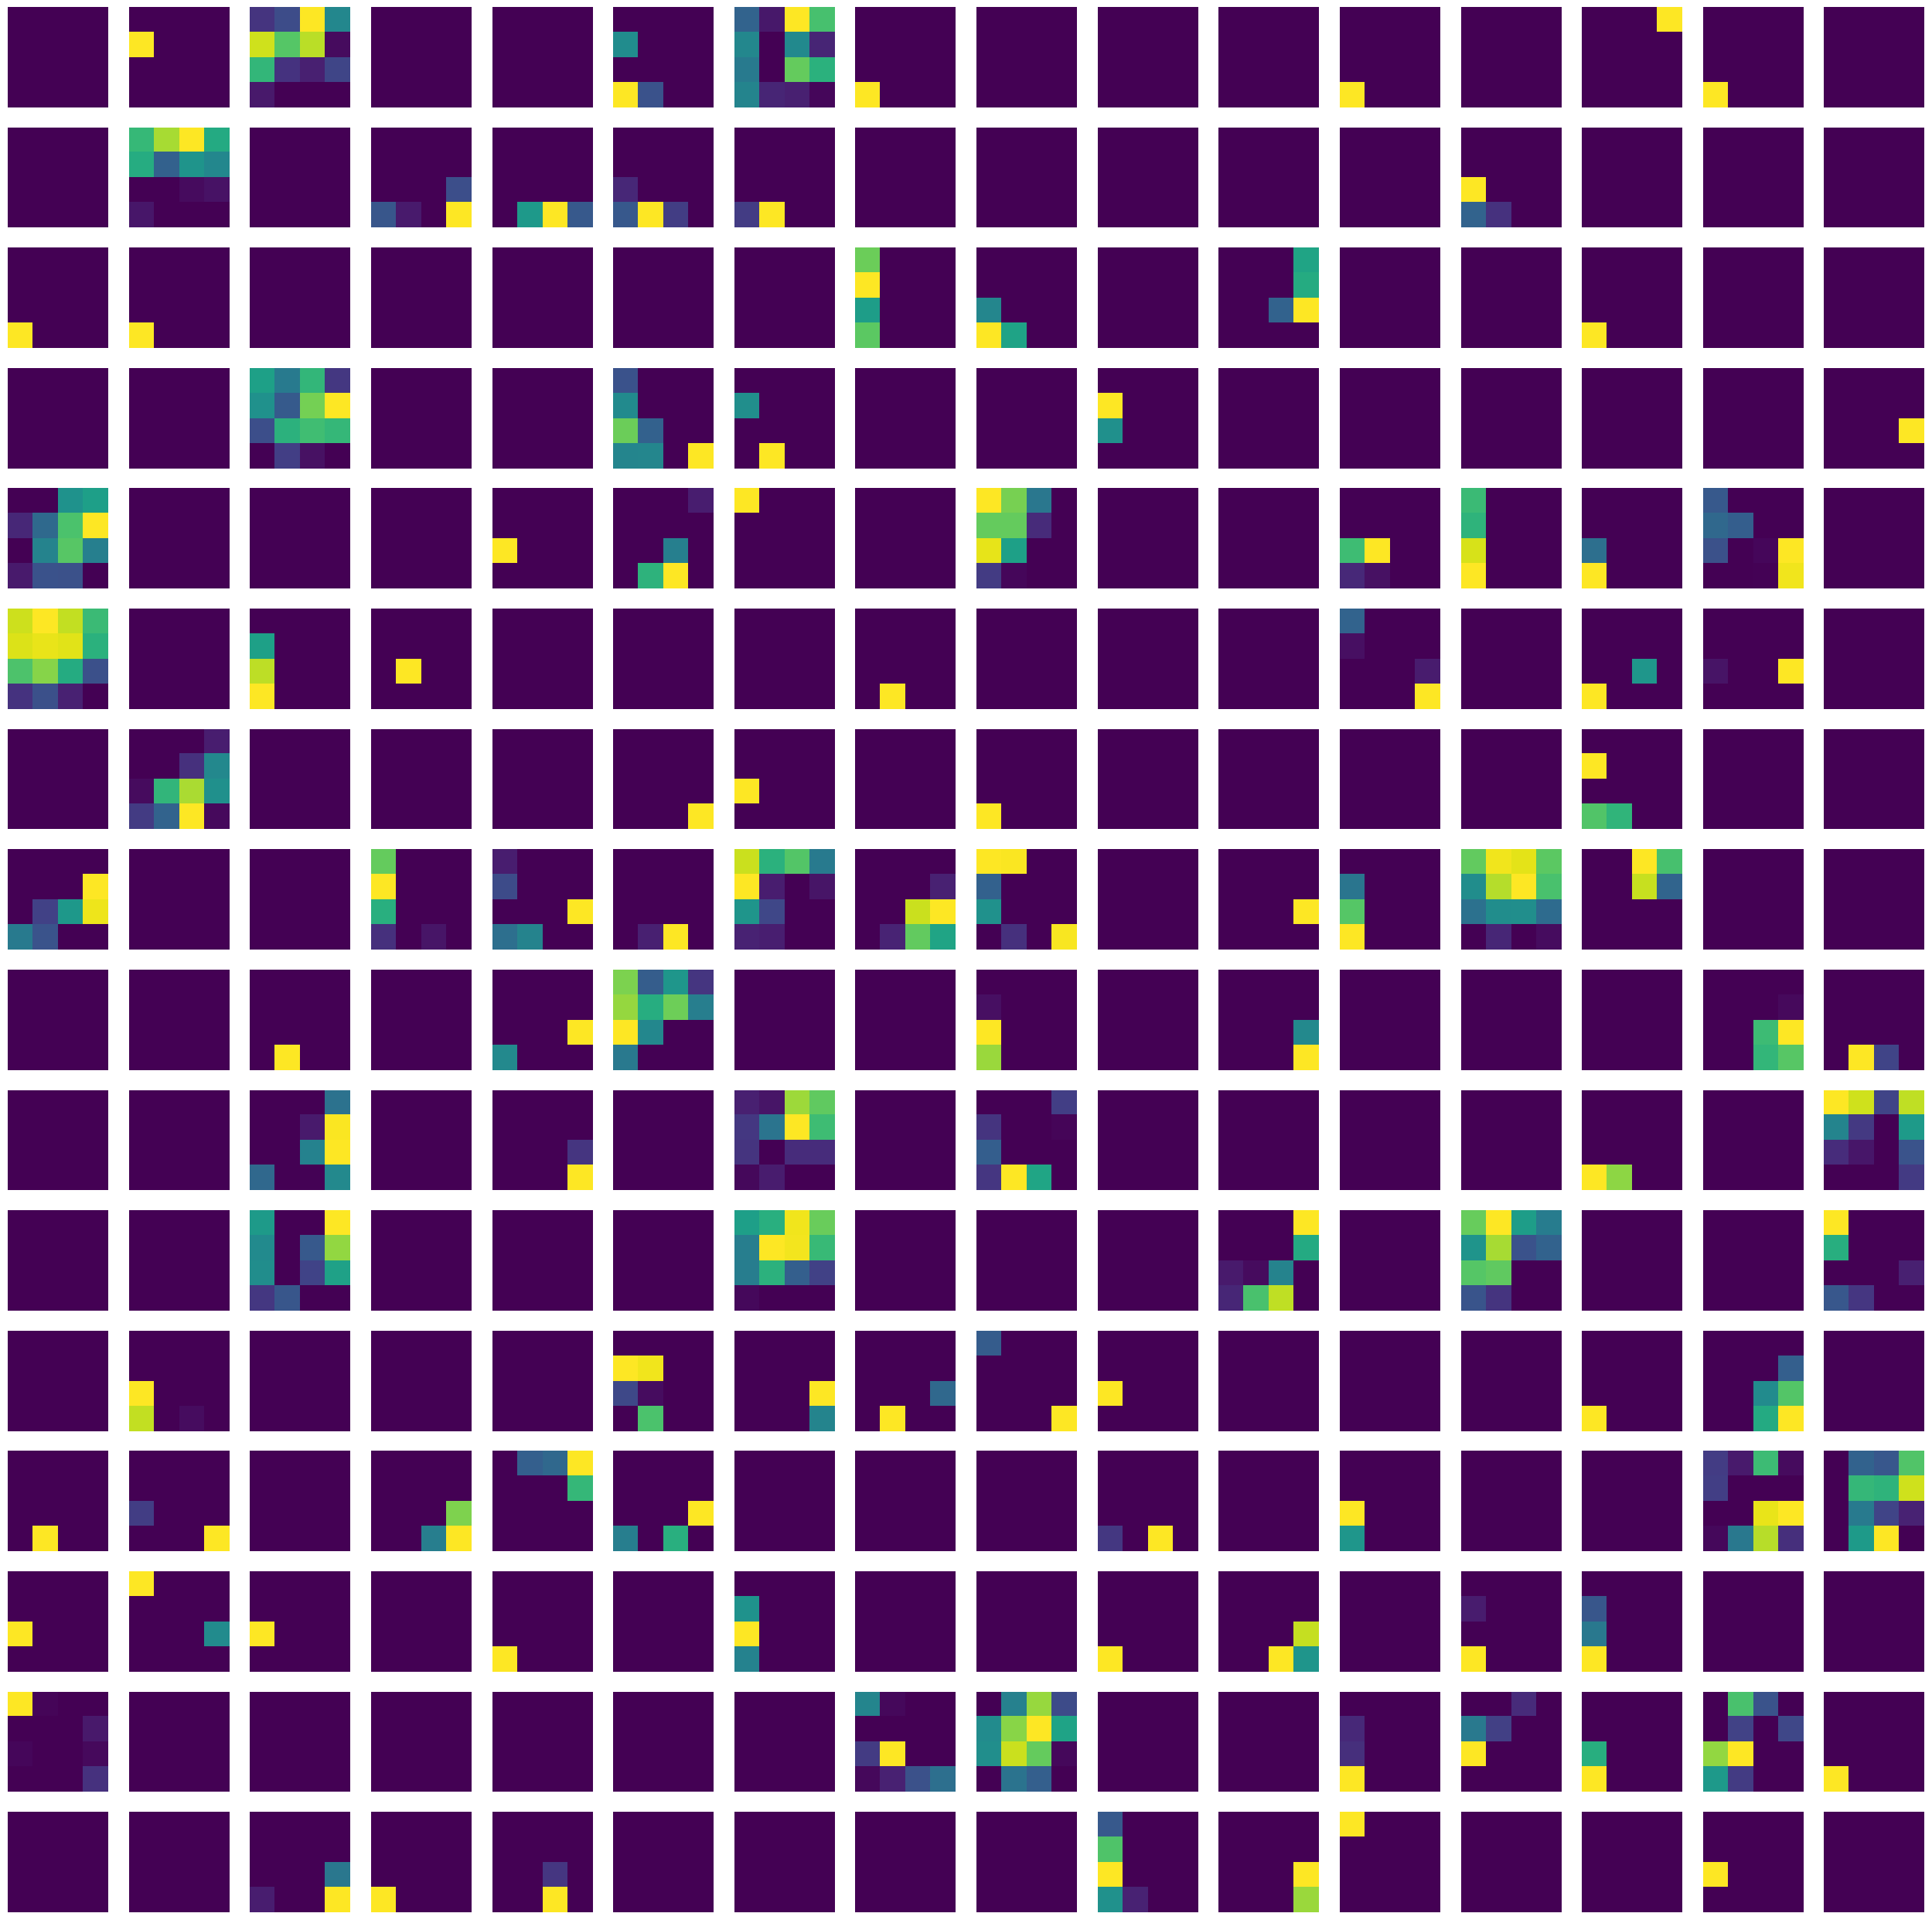

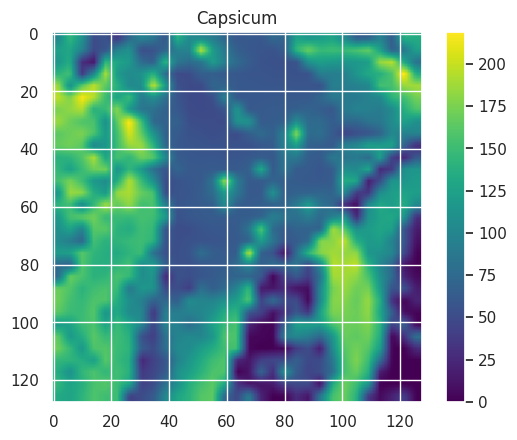

In [174]:
display_conv_activation(0, -6, figsize=(32, 32))
display_vege(0)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_large.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_large.fit(
    x = datagen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=50,
    batch_size=50,
    validation_data=(val_images, val_labels)
)

accuracy = model_large.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (128x128): {accuracy:.2f}")

Epoch 1/50
91/91 [==============================] - 13s 123ms/step - loss: 0.1808 - accuracy: 0.9448 - val_loss: 0.1637 - val_accuracy: 0.9540
Epoch 2/50
91/91 [==============================] - 12s 127ms/step - loss: 0.1521 - accuracy: 0.9507 - val_loss: 0.2843 - val_accuracy: 0.9230
Epoch 3/50
91/91 [==============================] - 12s 126ms/step - loss: 0.1607 - accuracy: 0.9487 - val_loss: 0.1613 - val_accuracy: 0.9553
Epoch 4/50
91/91 [==============================] - 12s 130ms/step - loss: 0.1483 - accuracy: 0.9540 - val_loss: 0.1490 - val_accuracy: 0.9587
Epoch 5/50
91/91 [==============================] - 11s 122ms/step - loss: 0.1498 - accuracy: 0.9507 - val_loss: 0.1943 - val_accuracy: 0.9450
Epoch 6/50
91/91 [==============================] - 11s 123ms/step - loss: 0.1681 - accuracy: 0.9453 - val_loss: 0.1628 - val_accuracy: 0.9527
Epoch 7/50
91/91 [==============================] - 12s 130ms/step - loss: 0.1326 - accuracy: 0.9586 - val_loss: 0.1588 - val_accuracy: 0.9520

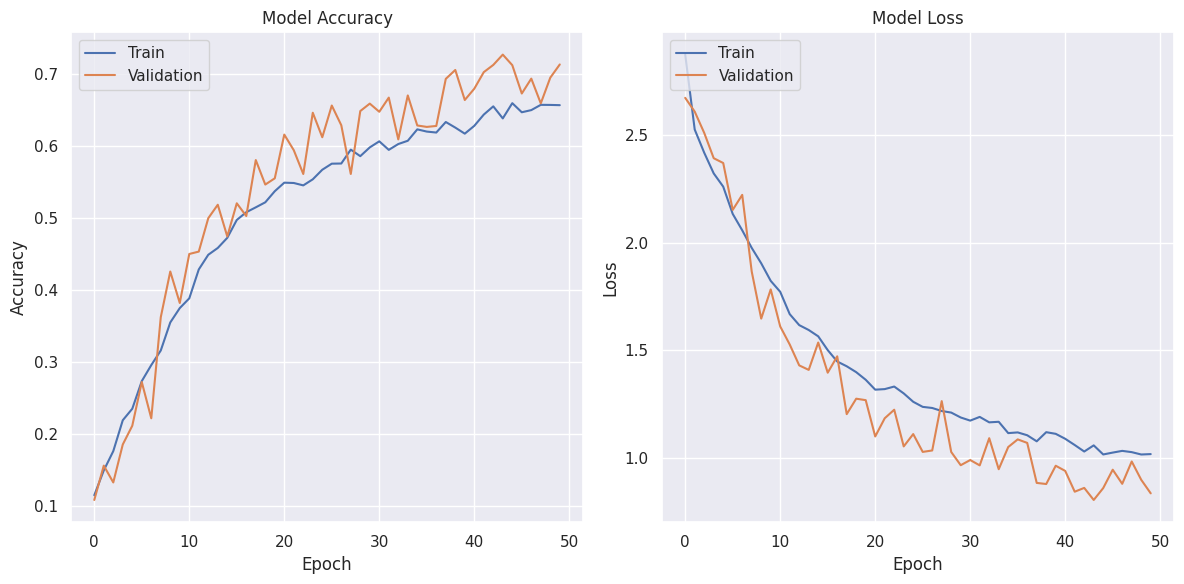

In [39]:
plot_history(history)

## Basic CNN with 
* Image Augmentation Preprocessing Layer
* Learning Rate Scheduling
* LeakyReLU Activation

In [41]:
model_small = Sequential([
    image_augmentation,
    resize_small,
    Conv2D(32, (3, 3), input_shape=(31, 31, 1)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(400),
    LeakyReLU(alpha=0.1),
    Dense(15, activation='softmax')
])

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000000, decay_rate=0.96, staircase=True)

custom_optimizer = Adam(learning_rate=lr_schedule)
model_small.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_small.fit(train_images, train_labels, epochs=50, batch_size=50, validation_data=(val_images, val_labels))

small_accuracy = model_small.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 6s 30ms/step - loss: 2.7678 - accuracy: 0.1379 - val_loss: 2.7177 - val_accuracy: 0.1270
Epoch 2/50
181/181 [==============================] - 5s 29ms/step - loss: 2.3865 - accuracy: 0.1865 - val_loss: 2.4109 - val_accuracy: 0.2263
Epoch 3/50
181/181 [==============================] - 5s 28ms/step - loss: 2.2570 - accuracy: 0.2383 - val_loss: 2.1434 - val_accuracy: 0.2737
Epoch 4/50
181/181 [==============================] - 5s 28ms/step - loss: 2.1374 - accuracy: 0.2727 - val_loss: 2.0482 - val_accuracy: 0.2747
Epoch 5/50
181/181 [==============================] - 5s 30ms/step - loss: 2.0181 - accuracy: 0.3137 - val_loss: 1.8278 - val_accuracy: 0.3890
Epoch 6/50
181/181 [==============================] - 5s 29ms/step - loss: 1.9487 - accuracy: 0.3344 - val_loss: 1.8695 - val_accuracy: 0.3407
Epoch 7/50
181/181 [==============================] - 5s 29ms/step - loss: 1.8109 - accuracy: 0.3806 - val_loss: 1.7950 - val_accuracy: 0.3880

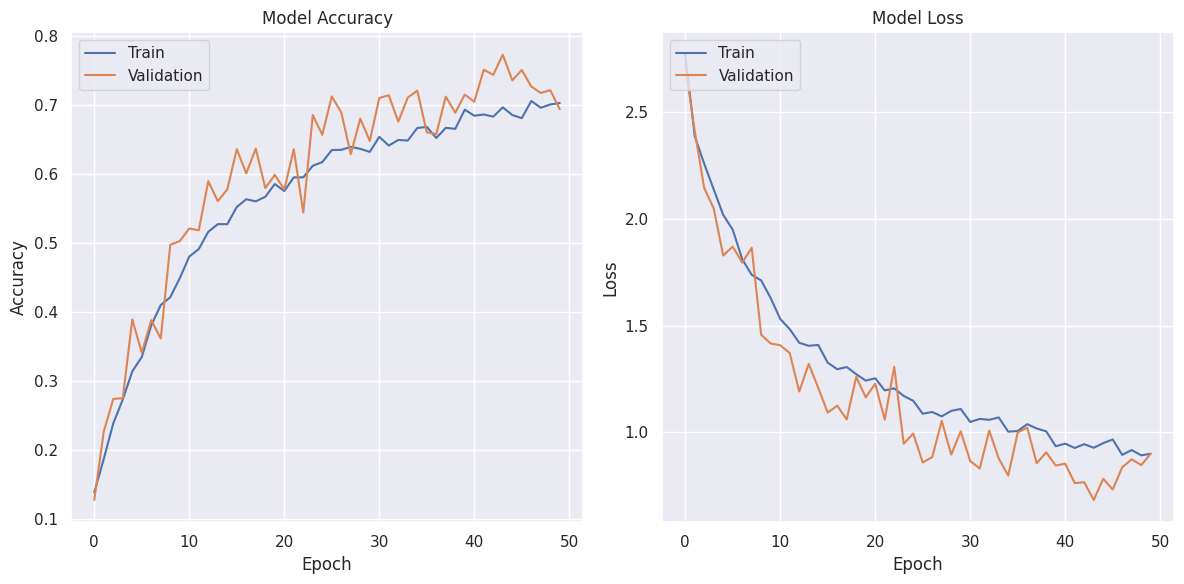

In [42]:
plot_history(history)

The peak validation accuracy has increased with LeakyReLU over ReLU so this seems like an improvement.

In [ ]:
model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1), kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for small images
history = model_small.fit(small_train_images, small_train_labels, epochs=10, batch_size=50, validation_data=(small_val_images, small_val_labels))

small_accuracy = model_small.evaluate(small_test_images, small_test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

history.history

In [ ]:

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),

In [ ]:
# Create the neural network model for small images
fast_model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

In [414]:
model_small.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_84 (Sequential)  (None, 224, 224, 1)       0         
                                                                 
 resizing_21 (Resizing)      (None, 31, 31, 1)         0         
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 32)        320       
                                                                 
 conv2d_101 (Conv2D)         (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 11, 11, 64)        36928     
                                                     

## Inception

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def inception_module(x, filters):
    conv1x1 = Conv2D(filters[0], kernel_size=1, padding='same')(x)
    conv1x1 = LeakyReLU(alpha=0.1)(conv1x1)
    conv3x3 = Conv2D(filters[1], kernel_size=3, padding='same', activation='relu')(x)
    conv3x3 = LeakyReLU(alpha=0.1)(conv3x3)
    conv5x5 = Conv2D(filters[2], kernel_size=5, padding='same', activation='relu')(x)
    conv5x5 = LeakyReLU(alpha=0.1)(conv5x5)
    maxpool = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    return concatenate([conv1x1, conv3x3, conv5x5, maxpool], axis=-1)

input_tensor = Input(shape=(31, 31, 1))
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = inception_module(x, [64, 64, 64])
x = inception_module(x, [64, 64, 64])
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

x = AveragePooling2D(pool_size=2, strides=1)(x)
x = Dropout(0.4)(x)  # Dropout for regularization
x = Flatten()(x)
output_tensor = Dense(15, activation='softmax')(x)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
custom_optimizer = Adam(learning_rate=lr_schedule)

inceptionv3_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
inceptionv3_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# resnet_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


# resnet_model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# from tensorflow.keras.applications import ResNet50
# resnet_model = ResNet50()

small_train_images = resize_small(train_images)
small_val_images = resize_small(val_images)
small_test_images = resize_small(test_images)

history = inceptionv3_model.fit(
    x = datagen.flow(small_train_images, train_labels, batch_size=50),
    epochs=50,
    batch_size=50,
    validation_data=(small_val_images, val_labels)
)

accuracy = inceptionv3_model.evaluate(small_test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {accuracy:.2f}")

Epoch 1/50
181/181 [==============================] - 2s 7ms/step - loss: 18.6188 - accuracy: 0.1007 - val_loss: 6.4683 - val_accuracy: 0.1267
Epoch 2/50
181/181 [==============================] - 1s 7ms/step - loss: 7.5740 - accuracy: 0.1289 - val_loss: 4.6527 - val_accuracy: 0.1473
Epoch 3/50
181/181 [==============================] - 1s 7ms/step - loss: 5.4479 - accuracy: 0.1410 - val_loss: 4.2016 - val_accuracy: 0.1287
Epoch 4/50
181/181 [==============================] - 1s 7ms/step - loss: 4.5500 - accuracy: 0.1464 - val_loss: 4.1185 - val_accuracy: 0.1463
Epoch 5/50
181/181 [==============================] - 1s 7ms/step - loss: 4.0469 - accuracy: 0.1525 - val_loss: 3.8638 - val_accuracy: 0.1570
Epoch 6/50
181/181 [==============================] - 1s 7ms/step - loss: 3.7839 - accuracy: 0.1592 - val_loss: 3.9134 - val_accuracy: 0.1437
Epoch 7/50
 25/181 [===>..........................] - ETA: 1s - loss: 3.7121 - accuracy: 0.1632

KeyboardInterrupt: 

In [26]:
inceptionv3_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 31, 31, 1)]          0         []                            
                                                                                                  
 conv2d_90 (Conv2D)          (None, 16, 16, 64)           3200      ['input_10[0][0]']            
                                                                                                  
 max_pooling2d_45 (MaxPooli  (None, 8, 8, 64)             0         ['conv2d_90[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_91 (Conv2D)          (None, 8, 8, 64)             4160      ['max_pooling2d_45[0][0]